In [ ]:
!pip install nilearn

In [2]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img, load_img
import nibabel as nib
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.linalg

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
#warnings.filterwarnings('ignore', category=np.linalg.LinAlgWarning)
warnings.filterwarnings('ignore', category=scipy.linalg.LinAlgWarning)

# **Dataset A**

In [23]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=200)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int) #gives 1 for females and 0 for males

### **Question 1**

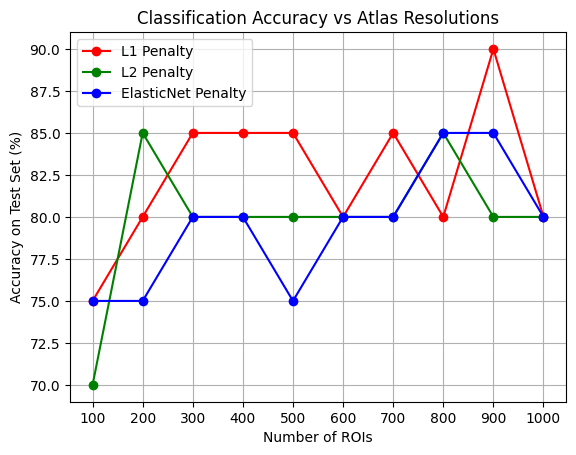

In [4]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
regions=list(range(100, 1100, 100)) # List of atlas resolutions
accuracies_l1 , accuracies_l2, accuracies_elastic= [], [], [] # Lists to store accuracies

for region in regions: # Iterate over different atlas resolutions
  yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region)
  masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
  input_variables = masker.fit_transform(brain_data.gray_matter_maps)
  output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)

  # Set first 80 brain scans as train data:
  X_train, y_train = input_variables[:80], output_variable[:80]
  # Set remaining 20 scans as test data:
  X_test, y_test = input_variables[80:], output_variable[80:]

  # Create & fit log models with the three penalty types
  logmodel_l1_q1 = LogisticRegression(penalty='l1', C=1.0, solver='saga')
  logmodel_l2_q1 = LogisticRegression(penalty='l2', C=1.0, solver='saga')
  logmodel_elastic_q1 = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga')
  
  logmodel_l1_q1.fit(X_train, y_train) # Fit l1 model
  logmodel_l2_q1.fit(X_train, y_train) # Fit l2 model
  logmodel_elastic_q1.fit(X_train, y_train) # Fit elastic model

  # Evaluate models on the test data
  acc_l1 = accuracy_score(y_test, logmodel_l1_q1.predict(X_test))*100
  acc_l2 = accuracy_score(y_test, logmodel_l2_q1.predict(X_test))*100
  acc_elastic = accuracy_score(y_test, logmodel_elastic_q1.predict(X_test))*100

  # Store accuracies
  accuracies_l1.append(acc_l1)
  accuracies_l2.append(acc_l2)
  accuracies_elastic.append(acc_elastic)

# Plot the classification accuracies
plt.plot(regions, accuracies_l1, label='L1 Penalty', marker='o', color='red')
plt.plot(regions, accuracies_l2, label='L2 Penalty', marker='o', color='green')
plt.plot(regions, accuracies_elastic, label='ElasticNet Penalty', marker='o', color='blue')
plt.xticks(regions)
plt.xlabel('Number of ROIs')
plt.ylabel('Accuracy on Test Set (%)')
plt.title('Classification Accuracy vs Atlas Resolutions')
plt.legend()
plt.grid(True)
plt.show()

### **Question 2**

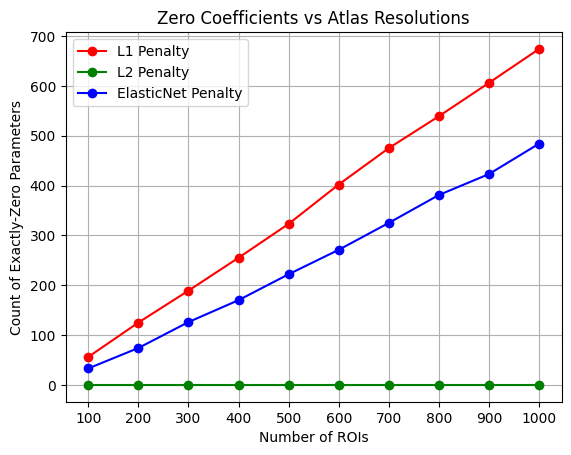

In [5]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
regions=list(range(100, 1100, 100)) # List of atlas resolutions
zeros_l1, zeros_l2, zeros_elastic = [], [], [] # Lists to store counts of zero parameters

for region in regions: # Iterate over different atlas resolutions
  yeo = datasets.fetch_atlas_schaefer_2018(n_rois=region)
  masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
  input_variables = masker.fit_transform(brain_data.gray_matter_maps)
  output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)

  # Set train & test data:
  X_train, y_train = input_variables[:80], output_variable[:80]
  X_test, y_test = input_variables[80:], output_variable[80:]

  # Create & fit log models with the three penalty types
  logmodel_l1_q2 = LogisticRegression(penalty='l1', C=1.0, solver='saga')
  logmodel_l2_q2 = LogisticRegression(penalty='l2', C=1.0, solver='saga')
  logmodel_elastic_q2 = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga')

  logmodel_l1_q2.fit(X_train, y_train) # Fit l1 model
  logmodel_l2_q2.fit(X_train, y_train)# Fit l2 model
  logmodel_elastic_q2.fit(X_train, y_train) # Fit elastic model

  # Count exactly-zero coefficients
  zeros_l1.append(np.sum(logmodel_l1_q2.coef_ == 0))
  zeros_l2.append(np.sum(logmodel_l2_q2.coef_ == 0))
  zeros_elastic.append(np.sum(logmodel_elastic_q2.coef_ == 0))

# Plot the count of exactly-zero parameters
plt.plot(regions, zeros_l1, label='L1 Penalty', marker='o', color='r')
plt.plot(regions, zeros_l2, label='L2 Penalty', marker='o', color='g')
plt.plot(regions, zeros_elastic, label='ElasticNet Penalty', marker='o', color='b')
plt.xticks(regions)
plt.xlabel('Number of ROIs')
plt.ylabel('Count of Exactly-Zero Parameters')
plt.title('Zero Coefficients vs Atlas Resolutions')
plt.legend()
plt.grid(True)
plt.show()

### **Question 3**

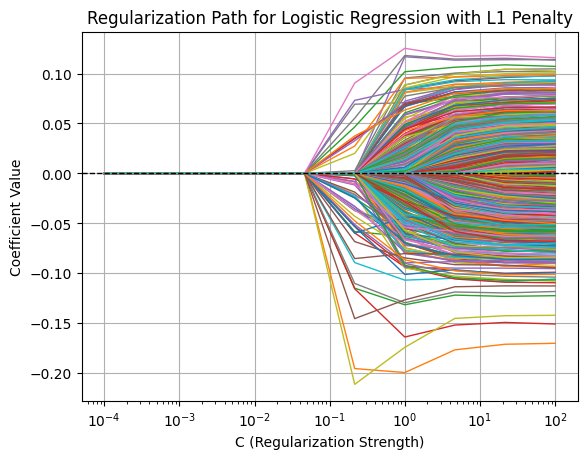

In [24]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=1000)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)

# Set train & test data:
X_train, y_train = input_variables[:80], output_variable[:80]
X_test, y_test = input_variables[80:], output_variable[80:]

C_values = np.logspace(-4, 2, 10)  # List of C values (small to large values)
coef_paths = [] # List to store the coefficients

for c in C_values: # Fit log models for each value of C
    logmodel_l1_q3 = LogisticRegression(penalty='l1', solver='saga', C=c) # Create log model
    logmodel_l1_q3.fit(X_train, y_train) # Fit log model
    coef_paths.append(logmodel_l1_q3.coef_.ravel())  # Store the coefficients for each C

coef_paths = np.array(coef_paths) # Convert to np array

for i in range(coef_paths.shape[1]): # Plot the regularization paths
    plt.plot(C_values, coef_paths[:,i], label=f'Coefficient {i+1}', lw=1)
plt.xscale('log')  # Use log scale for C values
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Regularization Path for Logistic Regression with L1 Penalty')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.grid(True)
plt.show()

### **Question 4**

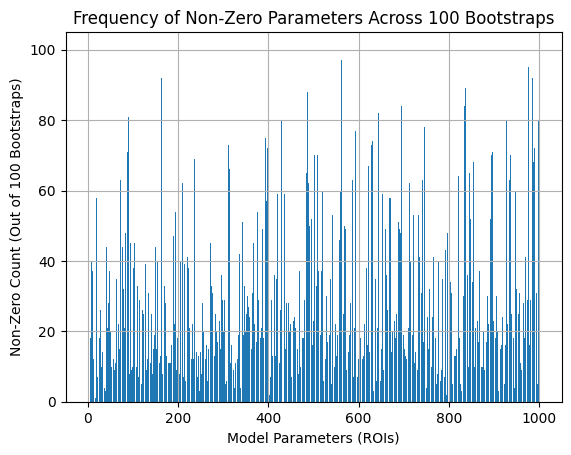

In [25]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
yeo = datasets.fetch_atlas_schaefer_2018(n_rois=1000)
masker = NiftiLabelsMasker(labels_img=yeo.maps, standardize=True, memory='nilearn_cache')
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = np.array(brain_data.ext_vars.mf == 'F', dtype=int)

# Set train & test data:
X_train, y_train = input_variables[:80], output_variable[:80]
X_test, y_test = input_variables[80:], output_variable[80:]

non_zero_counts = np.zeros(X_train.shape[1]) # List to store counts of non-zero coefs

for i in range(100): # Perform 100 bootstrap iterations
    X_resampled, y_resampled = resample(X_train, y_train) # Resample training data
    logreg_l1_q4 = LogisticRegression(penalty='l1', solver='saga', C=1.0) # Create log model
    logreg_l1_q4.fit(X_resampled, y_resampled) # Fit model on resampled train data
    non_zero_counts += (logreg_l1_q4.coef_.ravel() != 0) # Count non-zero coefs

# Plot occurrence of non-zero params across 100 bootstrap models:
plt.bar(range(1, X_train.shape[1] + 1), non_zero_counts)
plt.xlabel('Model Parameters (ROIs)')
plt.ylabel('Non-Zero Count (Out of 100 Bootstraps)')
plt.title('Frequency of Non-Zero Parameters Across 100 Bootstraps')
plt.grid(True)
plt.show()

### **Question 5**

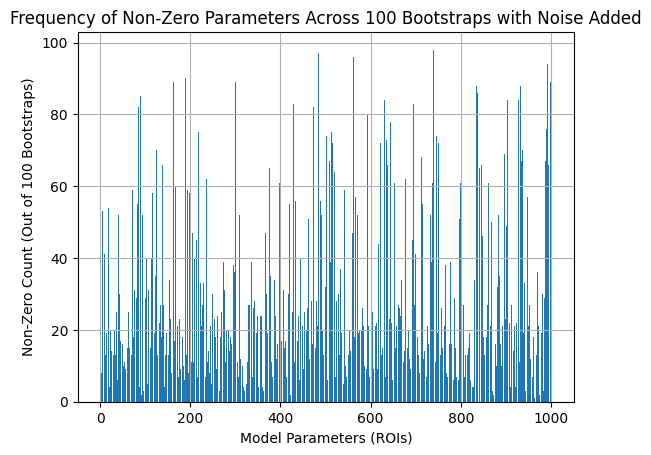

In [26]:
np.random.seed(0) # Set seed
# Set train & test data:
X_train, y_train = input_variables[:80], output_variable[:80]
X_test, y_test = input_variables[80:], output_variable[80:]

non_zero_counts = np.zeros(X_train.shape[1]) # Array to store counts of non-zero coefs

for i in range(100): # Perform 100 bootstrap iterations
    X_resampled, y_resampled = resample(X_train, y_train) # Resample training data
    noise = np.random.randn(*X_resampled.shape) * 0.1 # Add noise to resampled data
    X_resampled_noisy = X_resampled + noise # Add noise to resampled data
    logreg_l1_q5 = LogisticRegression(penalty='l1', solver='saga', C=1.0) # Create log model
    logreg_l1_q5.fit(X_resampled_noisy, y_resampled) # Fit model
    non_zero_counts += (logreg_l1_q5.coef_.ravel() != 0) # Count non-zero coefs

# Plot the frequency of non-zero params for 100 bootstrap models
plt.bar(range(1, X_train.shape[1] + 1), non_zero_counts)
plt.xlabel('Model Parameters (ROIs)')
plt.ylabel('Non-Zero Count (Out of 100 Bootstraps)')
plt.title('Frequency of Non-Zero Parameters Across 100 Bootstraps with Noise Added')
plt.grid(True)
plt.show()

# **Dataset B**

In [27]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] 
# gives subject age on standard units after z-scoring

### **Question 6**

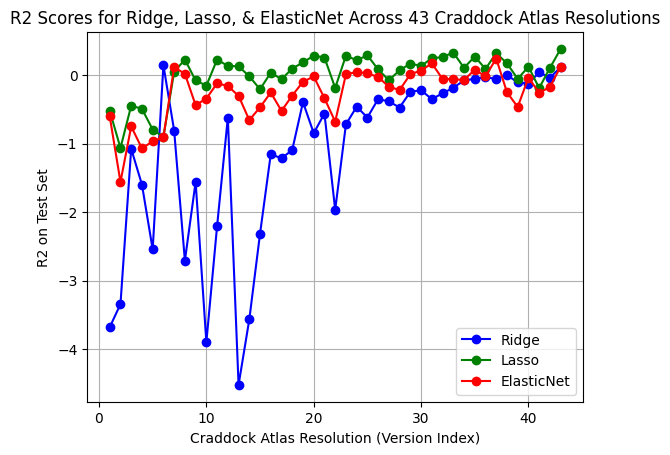

In [15]:
ridge_q6 = Ridge(alpha=0.1) # Create Ridge model with alpha=0.1
lasso_q6 = Lasso(alpha=0.1) # Create Lasso model with alpha=0.1
elasticnet_q6 = ElasticNet(alpha=0.1, l1_ratio=0.5) # Create ElasticNet model with alpha=0.1

ridge_r2_scores, lasso_r2_scores, elasticnet_r2_scores = [], [], [] # Lists to store R2 values

for i in range(43): # Iterate over 43 Craddock atlas resolutions
    atlas_nii = index_img(crad['scorr_mean'], i)
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0]
    
    # Set train & test data:
    X_train, y_train = input_variables[:80], output_variable[:80]
    X_test, y_test = input_variables[80:], output_variable[80:]

    ridge_q6.fit(X_train, y_train) # Fit Ridge model
    y_pred_ridge = ridge_q6.predict(X_test) # Predict on test data
    ridge_r2_scores.append(r2_score(y_test, y_pred_ridge)) # Store R2 score

    lasso_q6.fit(X_train, y_train) # Fit Lasso model
    y_pred_lasso = lasso_q6.predict(X_test) # Predict on test data
    lasso_r2_scores.append(r2_score(y_test, y_pred_lasso)) # Store R2 score

    elasticnet_q6.fit(X_train, y_train) # Fit ElasticNet model
    y_pred_elasticnet = elasticnet_q6.predict(X_test) # Predict on test data
    elasticnet_r2_scores.append(r2_score(y_test, y_pred_elasticnet)) # Store R2 score

# Plot R2 scores for the test set across atlas resolutions
atlas_numbers = list(range(1, 44))
plt.plot(atlas_numbers, ridge_r2_scores, label='Ridge', color='blue', marker='o')
plt.plot(atlas_numbers, lasso_r2_scores, label='Lasso', color='green', marker='o')
plt.plot(atlas_numbers, elasticnet_r2_scores, label='ElasticNet', color='red', marker='o')
plt.xlabel('Craddock Atlas Resolution (Version Index)')
plt.ylabel('R2 on Test Set')
plt.title('R2 Scores for Ridge, Lasso, & ElasticNet Across 43 Craddock Atlas Resolutions')
plt.legend()
plt.grid(True)
plt.show()

### **Question 7**

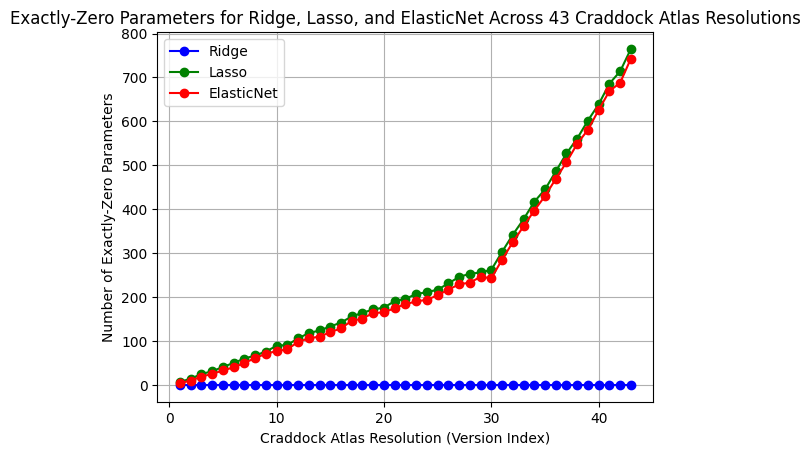

In [16]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()

ridge_q7 = Ridge(alpha=0.1) # Create Ridge model with alpha=0.1
lasso_q7 = Lasso(alpha=0.1) # Create Lasso model with alpha=0.1
elasticnet_q7 = ElasticNet(alpha=0.1, l1_ratio=0.5) # Create ElasticNet model with alpha=0.1

ridge_zero_counts, lasso_zero_counts,elasticnet_zero_counts  = [], [], [] # Lists for counts of zero params

for i in range(43): # Iterate over 43 Craddock atlas resolutions
    atlas_nii = index_img(crad['scorr_mean'], i)
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
    input_variables = masker.fit_transform(brain_data.gray_matter_maps)
    output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0]
    
    # Set train & test data:
    X_train, y_train = input_variables[:80], output_variable[:80]
    X_test, y_test = input_variables[80:], output_variable[80:]

    ridge_q7.fit(X_train, y_train) # Fit Ridge regression
    ridge_zero_counts.append(np.sum(ridge_q7.coef_ == 0)) # Store exactly zero counts

    lasso_q7.fit(X_train, y_train) # Fit Lasso regression
    lasso_zero_counts.append(np.sum(lasso_q7.coef_ == 0)) # Store exactly zero counts

    elasticnet_q7.fit(X_train, y_train) # Fit ElasticNet regression
    elasticnet_zero_counts.append(np.sum(elasticnet_q7.coef_ == 0)) # Store exactly zero counts

# Plot the number of exactly-zero parameters across atlas resolutions
atlas_numbers = list(range(1, 44))  # 43 atlas versions
plt.plot(atlas_numbers, ridge_zero_counts, label='Ridge', color='blue', marker='o')
plt.plot(atlas_numbers, lasso_zero_counts, label='Lasso', color='green', marker='o')
plt.plot(atlas_numbers, elasticnet_zero_counts, label='ElasticNet', color='red', marker='o')
plt.xlabel('Craddock Atlas Resolution (Version Index)')
plt.ylabel('Number of Exactly-Zero Parameters')
plt.title('Exactly-Zero Parameters for Ridge, Lasso, and ElasticNet Across 43 Craddock Atlas Resolutions')
plt.legend()
plt.grid(True)
plt.show()

### **Question 8**

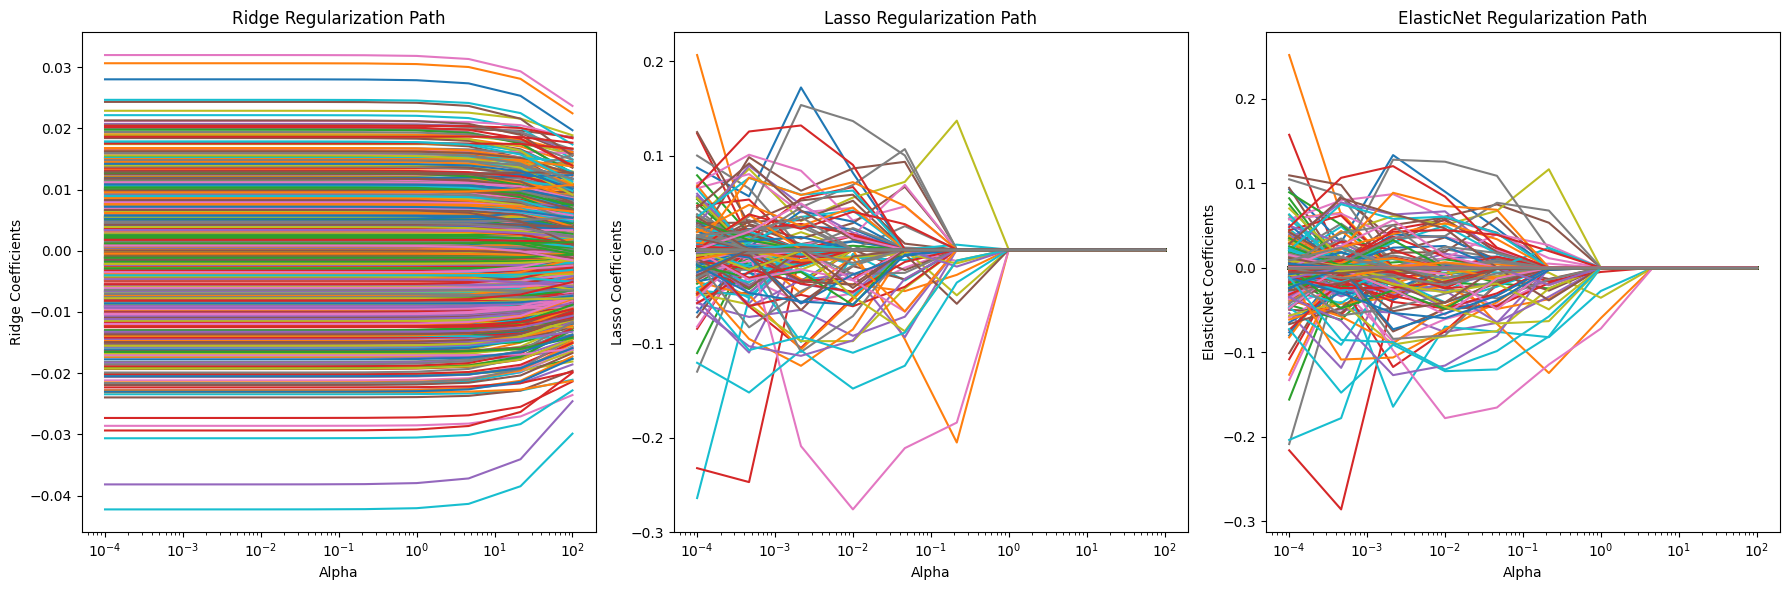

In [28]:
brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
atlas_nii = index_img(crad['scorr_mean'], 42) # this needs to be modified for some tasks
masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
input_variables = masker.fit_transform(brain_data.gray_matter_maps)
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:,0]

# Set train & test data:
X_train, y_train = input_variables[:80], output_variable[:80]
X_test, y_test = input_variables[80:], output_variable[80:]

alpha_grid = np.logspace(-4, 2, 10) # Get alpha values
ridge_coefs, lasso_coefs, elasticnet_coefs = [], [], [] # Lists to store coefs for each model

for alpha in alpha_grid: # Iterate through each alpha value
    ridge_q8 = Ridge(alpha=alpha) # Ridge regression
    ridge_q8.fit(X_train, y_train) # Fit Ridge model
    ridge_coefs.append(ridge_q8.coef_) # Add coefs to list

    lasso_q8 = Lasso(alpha=alpha) # Lasso regression
    lasso_q8.fit(X_train, y_train) # Fit Lasso model
    lasso_coefs.append(lasso_q8.coef_) # Add coefs to list

    elasticnet_q8 = ElasticNet(alpha=alpha, l1_ratio=0.5) # ElasticNet regression
    elasticnet_q8.fit(X_train, y_train) # Fit model
    elasticnet_coefs.append(elasticnet_q8.coef_) # Add coefs to list

# Convert coefs lists to arrays
ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)
elasticnet_coefs = np.array(elasticnet_coefs)

# Plot regularization path for each model:
plt.figure(figsize=(18, 6))
# Ridge regression coefs plot
plt.subplot(1, 3, 1)
plt.plot(alpha_grid, ridge_coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Ridge Coefficients')
plt.title('Ridge Regularization Path')
# Lasso regression coefs plot
plt.subplot(1, 3, 2)
plt.plot(alpha_grid, lasso_coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Lasso Coefficients')
plt.title('Lasso Regularization Path')
# ElasticNet regression coefs plot
plt.subplot(1, 3, 3)
plt.plot(alpha_grid, elasticnet_coefs)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('ElasticNet Coefficients')
plt.title('ElasticNet Regularization Path')
plt.tight_layout()
plt.show()

### **Question 9**

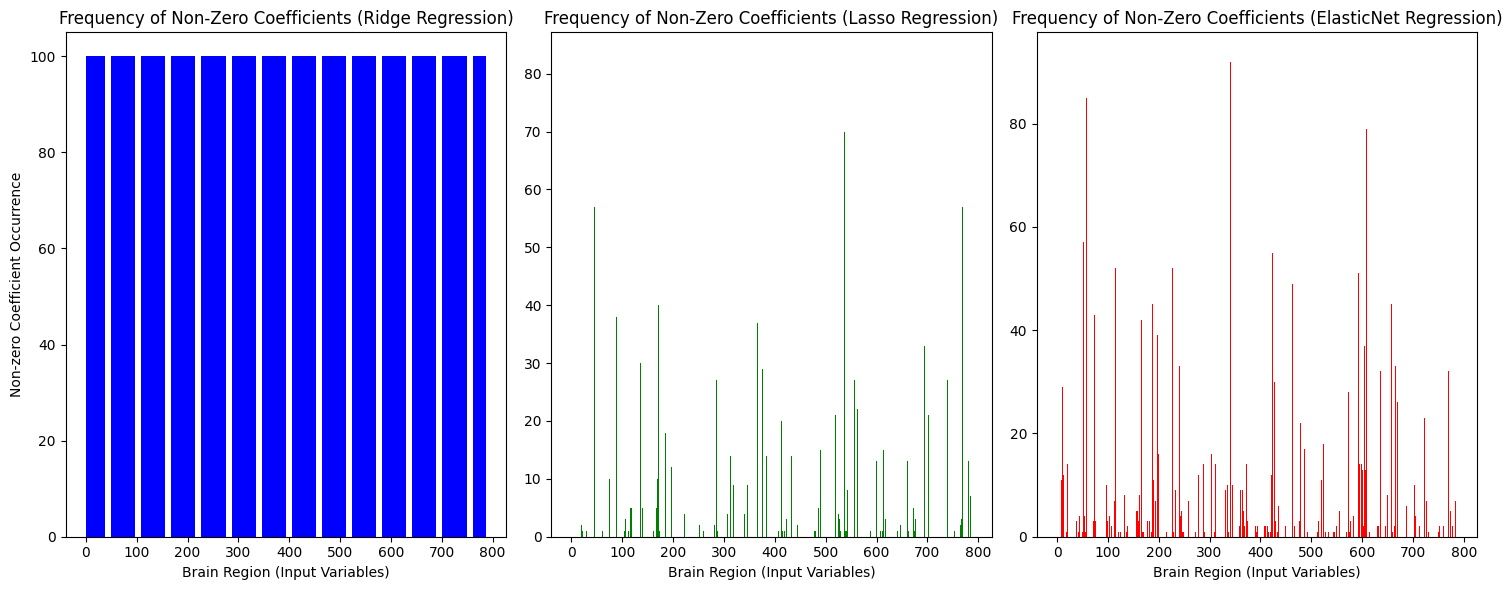

In [38]:
np.random.seed(0) # Set seed
# Store non-zero coefs counts for each model
non_zero_counts_ridge = np.zeros(X_train.shape[1])
non_zero_counts_lasso = np.zeros(X_train.shape[1])
non_zero_counts_elasticnet = np.zeros(X_train.shape[1])

for i in range(100): # Perform 100 bootstrap iterations
    X_resampled, y_resampled = resample(X_train, y_train) # Resample data

    ridge_model = Ridge(alpha=0.1) # Create Ridge model
    ridge_model.fit(X_resampled, y_resampled) # Fit Ridge model
    non_zero_counts_ridge += (ridge_model.coef_ != 0) # Count non-zero coefs

    lasso_model = Lasso(alpha=0.1) # Create Lasso model
    lasso_model.fit(X_resampled, y_resampled) # Fit Lasso model
    non_zero_counts_lasso += (lasso_model.coef_ != 0) # Count non-zero coefs

    elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5) # Create ElasticNet model
    elasticnet_model.fit(X_resampled, y_resampled) # Fit ElasticNet model
    non_zero_counts_elasticnet += (elasticnet_model.coef_ != 0) # Count non-zero coefs

# Plot the occurrence of non-zero model parameters for all three models
plt.figure(figsize=(15, 6))
# Ridge plot
plt.subplot(1, 3, 1)
plt.bar(range(X_train.shape[1]), non_zero_counts_ridge, color='blue')
plt.xlabel('Brain Region (Input Variables)')
plt.ylabel('Non-zero Coefficient Occurrence')
plt.title('Frequency of Non-Zero Coefficients (Ridge Regression)')
# Lasso plot
plt.subplot(1, 3, 2)
plt.bar(range(X_train.shape[1]), non_zero_counts_lasso, color='green')
plt.xlabel('Brain Region (Input Variables)')
plt.title('Frequency of Non-Zero Coefficients (Lasso Regression)')
# ElasticNet plot
plt.subplot(1, 3, 3)
plt.bar(range(X_train.shape[1]), non_zero_counts_elasticnet, color='red')
plt.xlabel('Brain Region (Input Variables)')
plt.title('Frequency of Non-Zero Coefficients (ElasticNet Regression)')
plt.tight_layout()
plt.show()

### **Question 10**

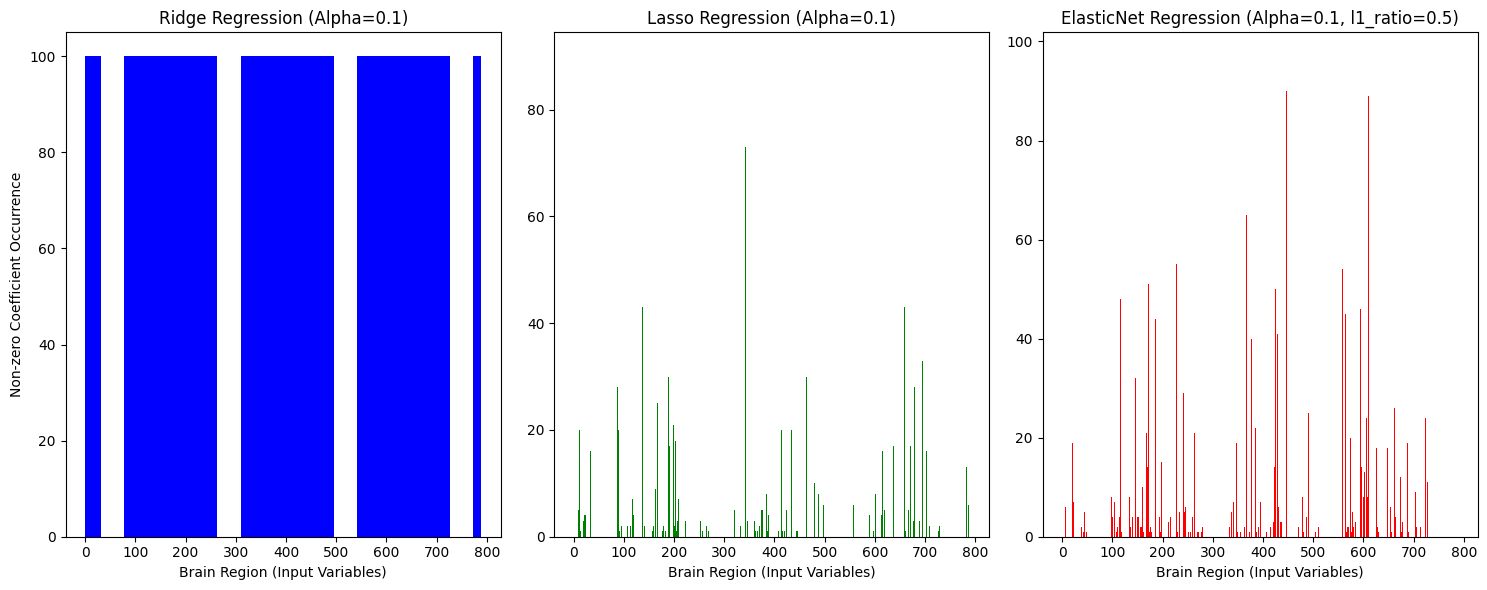

In [39]:
np.random.seed(0) # Set seed
# Arrays to store counts of non-zero coefficients
non_zero_counts_ridge = np.zeros(X_train.shape[1])
non_zero_counts_lasso = np.zeros(X_train.shape[1])
non_zero_counts_elasticnet = np.zeros(X_train.shape[1])

for i in range(100): # Perform 100 bootstrap iterations
    X_resampled, y_resampled = resample(X_train, y_train) # Resample data

    # Add noise to resampled input data
    noise = np.random.randn(*X_resampled.shape) * 0.1
    X_resampled_noisy = X_resampled + noise

    ridge_model_q10 = Ridge(alpha=0.1) # Create Ridge model
    ridge_model_q10.fit(X_resampled_noisy, y_resampled) # Fit Ridge model
    non_zero_counts_ridge += (ridge_model_q10.coef_ != 0) # Count non-zero coefs

    lasso_model_q10 = Lasso(alpha=0.1) # Create Lasso model
    lasso_model_q10.fit(X_resampled_noisy, y_resampled) # Fit Lasso model
    non_zero_counts_lasso += (lasso_model_q10.coef_ != 0) # Count non-zero coefs

    elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5) # Create ElasticNet model
    elasticnet_model.fit(X_resampled_noisy, y_resampled) # Fit ElasticNet model
    non_zero_counts_elasticnet += (elasticnet_model.coef_ != 0) # Count non-zero coefs

# Plot the occurrence of non-zero model parameters for all three models
plt.figure(figsize=(15, 6))
# Ridge plot
plt.subplot(1, 3, 1)
plt.bar(range(1, X_train.shape[1] + 1), non_zero_counts_ridge, color='blue')
plt.xlabel('Brain Region (Input Variables)')
plt.ylabel('Non-zero Coefficient Occurrence')
plt.title('Ridge Regression (Alpha=0.1)')
# Lasso plot
plt.subplot(1, 3, 2)
plt.bar(range(1, X_train.shape[1] + 1), non_zero_counts_lasso, color='green')
plt.xlabel('Brain Region (Input Variables)')
plt.title('Lasso Regression (Alpha=0.1)')
# ElasticNet plot
plt.subplot(1, 3, 3)
plt.bar(range(1, X_train.shape[1] + 1), non_zero_counts_elasticnet, color='red')
plt.xlabel('Brain Region (Input Variables)')
plt.title('ElasticNet Regression (Alpha=0.1, l1_ratio=0.5)')
plt.tight_layout()
plt.show()